# API Final Assignment

In [1]:
import requests
import matplotlib.pyplot as plt
import random
import pandas as pd
import json

# Retrieving Toronto Business Yelp URLs

In [2]:
#The simple way would be to identify rating and review text by running a method to identify the list item from the HTML
#However, to create a balanced dataset, I have chosen to go with the approach to retrieve reviews from the corresponding star pages
def business_url_retrieve(url,no_api_calls,YELP_TOKEN):
    positive_url_links = []
    negative_url_links = []
    for call in range(no_api_calls):
        offset = call*50
        r = requests.get(url+str(offset), headers={"Authorization": "Bearer %s" % YELP_TOKEN})
        if (r.status_code==200):
        # Found that by adding the suffixes to the url, we are directed to the specific review rating pages. 5 - 5 star, 4 - 4 star, ...
        # Saves complexity by not requiring to scrape the rating and helps deal with class balance
        # Saves on total number of API calls required to gather a large dataset of reviews
            for business in r.json()['businesses']:
                positive_url_links.append(business['url']+"&rr=5") # 5 Star Reviews Page for Each Business (Positive)
                positive_url_links.append(business['url']+"&rr=4") # 4 Star Reviews Page for Each Business (Positive)
                negative_url_links.append(business['url']+"&rr=1") # 1 Star Reviews Page for Each Business (Negative)
                negative_url_links.append(business['url']+"&rr=2") # 2 Star Reviews Page for Each Business (Negative)
    return positive_url_links,negative_url_links

We get 50 Business's data for each API call, therefore for example, if we perform 10 API calls, we end up with information regarding 500 Businesses (1000 positive URLs - 500 5 Star URLs, 500 4 Star URLs & 1000 negative URLS - 500 1 Star URLs, 500 2 Star URLs)

WARNING: 5 API Calls Execution Time ~ 1.5 Hours

In [3]:
YELP_TOKEN = "INSERT_API_TOKEN"
no_api_calls = 4
url = "https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50&offset="

In [4]:
positive_url_links, negative_url_links = business_url_retrieve(url,no_api_calls,YELP_TOKEN)

In [5]:
print(len(positive_url_links))
print(len(negative_url_links))

400
400


# HTML Parsing

In [6]:
import requests
from bs4 import BeautifulSoup
import time
import urllib.parse as urlparse

In [7]:
def collect_review_text(url_list):
    reviews = []
    for url in url_list:
        url_data = requests.get(url)
        url_html_doc = BeautifulSoup(url_data.text,"html.parser")
        spans = url_html_doc.findAll(class_='raw__09f24__T4Ezm')
        # Avoiding the first and last few rows of the span, since it contains non-review information which is common across the URLs, there is a drawback for this that we may lose a few starting reviews but the trade-off is decrease in complexity and easier to collect more data
        for span in spans[8:-3]:
            reviews.append(span.text)
    return reviews

In [8]:
positive_reviews = collect_review_text(positive_url_links)

In [9]:
len(positive_reviews)

2490

Looking a random sample positive review.

In [10]:
random.seed(42)
positive_reviews[random.randint(0, len(positive_reviews))]

"Amazing food, great service. Every course was fantastic.We had tartare, smoked cabbage salad, bison ribeye, and a fish dish with lentils (forgetting which fish off the top of my head.)Everything was great. The bison ribeye was worth all $58 and then some. I'll be looking forward to getting that again for next time.They were even so sweet about my rapini intolerance (rip, I will miss you sweet delicious rapini.)AND THE FEATURE DESSERT!!! It was clementine cheesecake. It was light delicious, and fresh. It tasted like pure clementine, we even watched another table taste it to see how they'd react, and they were also delighted.Excited to come back, the wine was great and so were the cocktails. This place rules!!!"

In [11]:
negative_reviews = collect_review_text(negative_url_links)

In [12]:
len(negative_reviews)

1856

Looking a random sample negative review.

In [13]:
random.seed(42)
negative_reviews[random.randint(0, len(negative_reviews))]

"I'm picky with fish n chips. Yes, I'm a Madonna. It's so easy to screw up fish and chips. You'd think it's easy to cook, but there really is an art to it. The right batter with good seasoning, the right temperature to the oil, crisp fries and for the love of God, fresh fish! So given the great ratings on Yelp, I was pretty excited to finally have the chance to try Fresco's... and boy was I disappointed. I was expecting greatness, but what I got was a small portion of overcooked, dry and flavorless fish and soggy and under seasoned fries for $15.I had the halibut, and being my first time I had it done half and half (half regular batter, half Ms. Vickie's).  The Ms. Vickie's batter is definitely the better of the two, have more crunch and texture, while the regular batter was soft and just not good. The fish wasn't overly oily, which is good, but the fish itself was very dry.  You know how in good fish and chips, the fish will flake apart? That lovely texture that just falls apart in yo

# Combining the Lists

In [14]:
positive_reviews_final = [(x, 'positive') for (x) in positive_reviews]
negative_reviews_final = [(x, 'negative') for (x) in negative_reviews]

In [15]:
combined_list = positive_reviews_final + negative_reviews_final

In [16]:
print(combined_list[:5])

[('Hubby and I saw this place on YouTube\'s "Worth It" and we were curious and had to try this place out. Is it all hype or is it "Worth It?"I loved the Mango Slaw as I found it refreshing. I loved the textures of the sweetness of the mangos with the crunchiness of the taro sticks and peanuts. It is a must get, in my book. Hubby and I decided to go vegetarian for our entrees. Hubby ordered Tofu Pad Gra Prow which was very good while I ordered Tofu Khao Soi. There was a perfect balance between the curry and soup. The harmonious coconut milk with the stock made it the standout dish with its refreshing combination of flavors and textures. I truly appreciate the notion that they offer plenty of vegetarian food and can make any dish vegan. This is a trendy place and you should make reservations on Friday nights as well as the weekends. The service was fast and efficient. They offer dinner specials but the waitress explained everyone at the table would have to order it in order for it to com

# Extracting Data

In [17]:
df = pd.DataFrame(combined_list)
df.to_excel('scraped_reviews.xlsx', index=False,header=['Review Text',"Sentiment"])

In [18]:
output_file = 'data.json'
with open(output_file, 'w') as file:
    json.dump(combined_list, file)

Extracted JSON file - Reviews & Sentiment

In [19]:
file_path = 'data.json'
with open(file_path, 'r') as file:
    data = json.load(file)
data

[['Hubby and I saw this place on YouTube\'s "Worth It" and we were curious and had to try this place out. Is it all hype or is it "Worth It?"I loved the Mango Slaw as I found it refreshing. I loved the textures of the sweetness of the mangos with the crunchiness of the taro sticks and peanuts. It is a must get, in my book. Hubby and I decided to go vegetarian for our entrees. Hubby ordered Tofu Pad Gra Prow which was very good while I ordered Tofu Khao Soi. There was a perfect balance between the curry and soup. The harmonious coconut milk with the stock made it the standout dish with its refreshing combination of flavors and textures. I truly appreciate the notion that they offer plenty of vegetarian food and can make any dish vegan. This is a trendy place and you should make reservations on Friday nights as well as the weekends. The service was fast and efficient. They offer dinner specials but the waitress explained everyone at the table would have to order it in order for it to com

In [20]:
combined_list = [(x.split(' '), y) for (x, y) in combined_list]

In [21]:
print(combined_list[:5])

[(['Hubby', 'and', 'I', 'saw', 'this', 'place', 'on', "YouTube's", '"Worth', 'It"', 'and', 'we', 'were', 'curious', 'and', 'had', 'to', 'try', 'this', 'place', 'out.', 'Is', 'it', 'all', 'hype', 'or', 'is', 'it', '"Worth', 'It?"I', 'loved', 'the', 'Mango', 'Slaw', 'as', 'I', 'found', 'it', 'refreshing.', 'I', 'loved', 'the', 'textures', 'of', 'the', 'sweetness', 'of', 'the', 'mangos', 'with', 'the', 'crunchiness', 'of', 'the', 'taro', 'sticks', 'and', 'peanuts.', 'It', 'is', 'a', 'must', 'get,', 'in', 'my', 'book.', 'Hubby', 'and', 'I', 'decided', 'to', 'go', 'vegetarian', 'for', 'our', 'entrees.', 'Hubby', 'ordered', 'Tofu', 'Pad', 'Gra', 'Prow', 'which', 'was', 'very', 'good', 'while', 'I', 'ordered', 'Tofu', 'Khao', 'Soi.', 'There', 'was', 'a', 'perfect', 'balance', 'between', 'the', 'curry', 'and', 'soup.', 'The', 'harmonious', 'coconut', 'milk', 'with', 'the', 'stock', 'made', 'it', 'the', 'standout', 'dish', 'with', 'its', 'refreshing', 'combination', 'of', 'flavors', 'and', 'tex

In [22]:
random.shuffle(combined_list)

In [23]:
len(combined_list)

4346

In [30]:
print(combined_list[:5])

[(['Love', 'this', 'place!', '', 'Love,', 'love,', 'love', 'the', 'Curry', 'Beef', '&', 'Takosen', 'combo!', '', 'Salad', 'is', 'yummy', 'too'], 'positive'), (['Very', 'very', 'disappointed!!', 'We', 'are', 'going', 'a', 'lot', 'to', 'fine', 'restaurants', 'and', 'this', 'was', 'absolutely', 'bad', 'restaurant!!Not', 'mentioned', 'the', 'steaks', 'are', 'so', 'expensive!', 'And', 'we', 'waited', 'an', 'hour', 'and', 'half!!!', 'To', 'get', 'our', 'food', '!!', 'Too', 'bad', 'Michael', 'on', 'simco-', 'we', 'will', 'not', 'come', 'or', 'recommend', 'on', 'this', 'place', 'ever', 'again!!'], 'negative'), (["CHUBBY'SSSSSSSSSSSSSS!!!!!", 'Is', 'the', 'reason', 'why', 'i', 'wanna', 'go', 'back', 'to', 'Toronto.', 'The', 'moment', 'we', 'walked', 'through', 'the', 'door', 'the', 'VIBEZ', 'was', 'on', 'fire!!!', 'The', 'place', 'was', 'packed!', 'The', 'music', 'was', 'banging!', 'The', 'FOOD!', 'THE', 'FOOOOOOOOOOOD', 'WAS', 'TOP', 'KNOTCH!', 'Kia', 'was', 'our', 'server', 'she', 'was', 'GRE

# Visualization

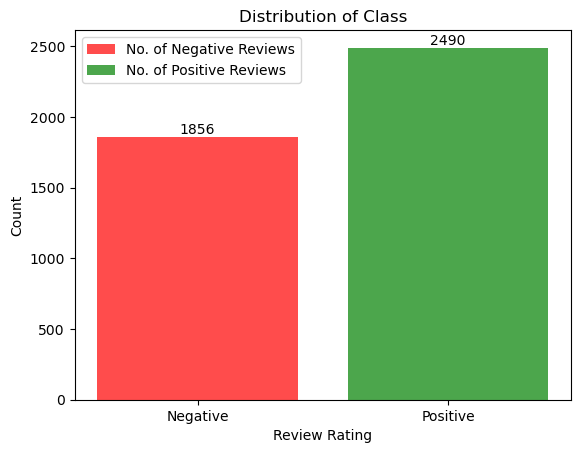

In [24]:
plt.bar("Negative",len(negative_reviews), alpha=0.7, label='No. of Negative Reviews',color='red')
plt.bar("Positive",len(positive_reviews), alpha=0.7, label='No. of Positive Reviews',color='green')
plt.text("Negative", len(negative_reviews) + 1, str(len(negative_reviews)), ha='center', va='bottom', fontsize=10)
plt.text("Positive", len(positive_reviews) + 1, str(len(positive_reviews)), ha='center', va='bottom', fontsize=10)

plt.xlabel('Review Rating')
plt.ylabel('Count')
plt.title('Distribution of Class')
plt.legend()

plt.show()

# Sentiment Analysis

In [25]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
#nltk.download('punkt')

#Setting test data set to 20% of the entire dataset
row_count = int(len(combined_list)*0.80)

training_docs = combined_list[:row_count]
test_docs = combined_list[row_count:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 3476, Testing: 870


In [26]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])
all_words_neg

['Love',
 'this',
 'place!',
 '',
 'Love,',
 'love,',
 'love',
 'the',
 'Curry',
 'Beef',
 '&',
 'Takosen',
 'combo!',
 '',
 'Salad',
 'is',
 'yummy',
 'too',
 'Very',
 'very',
 'disappointed!!',
 'We',
 'are',
 'going',
 'a',
 'lot',
 'to',
 'fine',
 'restaurants',
 'and',
 'this',
 'was',
 'absolutely',
 'bad',
 'restaurant!!Not',
 'mentioned',
 'the',
 'steaks',
 'are',
 'so',
 'expensive!',
 'And',
 'we',
 'waited',
 'an',
 'hour',
 'and',
 'half!!!',
 'To',
 'get',
 'our',
 'food',
 '!!',
 'Too',
 'bad',
 'Michael',
 'on',
 'simco-',
 'we',
 'will',
 'not',
 'come_NEG',
 'or_NEG',
 'recommend_NEG',
 'on_NEG',
 'this_NEG',
 'place_NEG',
 'ever_NEG',
 'again!!_NEG',
 "CHUBBY'SSSSSSSSSSSSSS!!!!!",
 'Is',
 'the',
 'reason',
 'why',
 'i',
 'wanna',
 'go',
 'back',
 'to',
 'Toronto.',
 'The',
 'moment',
 'we',
 'walked',
 'through',
 'the',
 'door',
 'the',
 'VIBEZ',
 'was',
 'on',
 'fire!!!',
 'The',
 'place',
 'was',
 'packed!',
 'The',
 'music',
 'was',
 'banging!',
 'The',
 'FOOD!',

In [27]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [28]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [29]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8310344827586207
F-measure [negative]: 0.7841409691629957
F-measure [positive]: 0.8611898016997166
Precision [negative]: 0.8612903225806452
Precision [positive]: 0.8142857142857143
Recall [negative]: 0.7196765498652291
Recall [positive]: 0.9138276553106213


In our day 3 notebook, we see that due to the class imbalance, the scores for the negative reviews are zero. Here, since we deal with the class imbalance by retrieving data from each of the star rating pages individually, we are able to amass a much more balanced dataset, thereby improving our predictive power.